#MNIST-based CNN Classifier model with the following characteristics:

- Less than 20,000 trainable parameters
- Uses Batch Normalization, Dropout (with low thresholds), and Global Average Pooling
- <20 training epochs for >99.4% accuracy

## 1️⃣ Imports and Device Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,random_split
from tqdm import tqdm
from torchsummary import summary
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import CosineAnnealingLR

ModuleNotFoundError: No module named 'torch'

In [2]:
# Use GPU if available for speed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA Available?", torch.cuda.is_available())

CUDA Available? True


## 2️⃣ Data Transformations (Augmentation for Train Only)


In [3]:
# Apply augmentation for training—center crop, rotation, resize, normalization
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(22)], p=0.1),
    #transforms.Resize((28, 28)),
    transforms.RandomRotation(7),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test data: only normalization
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## 3️⃣ Dataset and DataLoader Preparation

In [4]:
# Download and transform full train dataset (60k samples)
full_train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)

# Split into 50k training + 10k "test" (validation considered test)
train_size = 50000
test_size = 10000
train_data, test_data = random_split(full_train, [train_size, test_size])

batch_size = 64
# Efficient multi-processing and GPU-friendly DataLoader config
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.25MB/s]


## 4️⃣ Visualize A Sample Training Batch


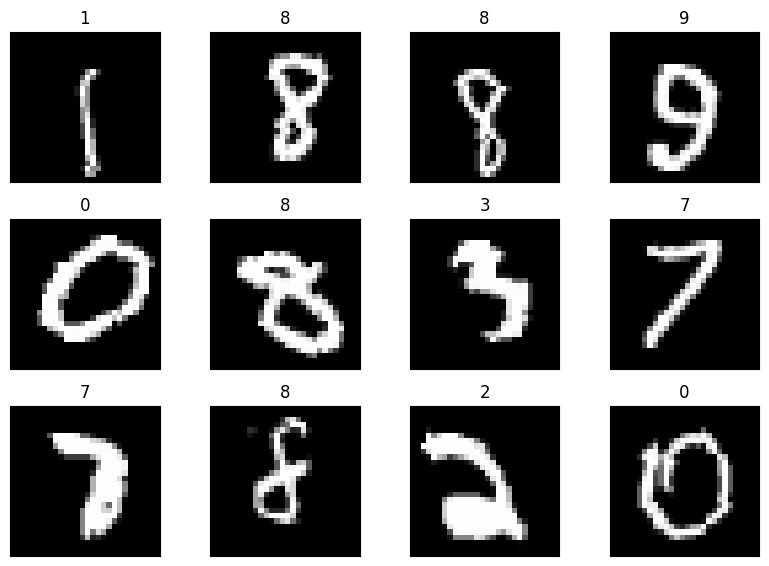

In [5]:
sample_batch, sample_labels = next(iter(train_loader))
fig = plt.figure(figsize=(8, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(sample_batch[i].squeeze(0), cmap='gray')
    plt.title(str(sample_labels[i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()

## 5️⃣ Model Definition


In [6]:
class DSConv(nn.Module):
    def __init__(self, in_c, out_c, k=3, s=1, p=1, dilation=1):
        super().__init__()
        self.dw = nn.Conv2d(in_c, in_c, k, s, p, groups=in_c, bias=False, dilation=dilation)
        self.pw = nn.Conv2d(in_c, out_c, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class SE(nn.Module):
    def __init__(self, c, r=12):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(c, c // r, 1, bias=True)
        self.fc2 = nn.Conv2d(c // r, c, 1, bias=True)
        self.act = nn.ReLU(inplace=True)
        self.gate = nn.Sigmoid()

    def forward(self, x):
        w = self.pool(x)
        w = self.act(self.fc1(w))
        w = self.gate(self.fc2(w))
        return x * w

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1, bias=False),   # 1 -> 16
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )

        # 28x28 -> 28x28
        self.block1 = DSConv(16, 32, k=3, s=1, p=1, dilation=1)   # 16 -> 32
        self.pool1  = nn.MaxPool2d(2, 2)                          # 28 -> 14

        # 14x14 -> 14x14
        self.block2 = DSConv(32, 64, k=3, s=1, p=1, dilation=1)   # 32 -> 64
        self.block3 = DSConv(64, 64, k=3, s=1, p=2, dilation=2)   # dilation to grow RF
        self.pool2  = nn.MaxPool2d(2, 2)                          # 14 -> 7

        # 7x7 -> 7x7
        self.block4 = DSConv(64, 96, k=3, s=1, p=2, dilation=2)   # 64 -> 96
        self.se     = SE(96, r=12)

        self.gap  = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(0.03)
        self.fc   = nn.Linear(96, num_classes)

    def forward(self, x):
        x = self.stem(x)            # 16x28x28
        x = self.block1(x)          # 32x28x28
        x = self.pool1(x)           # 32x14x14

        x = self.block2(x)          # 64x14x14
        x = self.block3(x)          # 64x14x14 (dilated)
        x = self.pool2(x)           # 64x7x7

        x = self.block4(x)          # 96x7x7 (dilated)
        x = self.se(x)              # 96x7x7

        x = self.gap(x).view(x.size(0), -1)  # 96
        x = self.drop(x)
        x = self.fc(x)              # 10
        return x

model = CNN().to(device)


## 6️⃣ Model Summary


In [7]:
summary(model, input_size=(1, 28, 28))
print('Total parameters:', sum(p.numel() for p in model.parameters()))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]             144
            Conv2d-5           [-1, 32, 28, 28]             512
       BatchNorm2d-6           [-1, 32, 28, 28]              64
              ReLU-7           [-1, 32, 28, 28]               0
            DSConv-8           [-1, 32, 28, 28]               0
         MaxPool2d-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]             288
           Conv2d-11           [-1, 64, 14, 14]           2,048
      BatchNorm2d-12           [-1, 64, 14, 14]             128
             ReLU-13           [-1, 64, 14, 14]               0
           DSConv-14           [-1, 64,

## 7️⃣ Loss Tracking & Logging Structures


In [8]:
# Store losses/accuracies for plotting
train_losses = []
test_losses = []
train_acc = []
test_acc = []
# Store incorrect test predictions (for further analysis if needed)
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}


## 8️⃣ Accuracy Helper Function


In [9]:
def GetCorrectPredCount(prediction, labels):
    return prediction.argmax(dim=1).eq(labels).sum().item()


## 9️⃣ Training and Testing Functions (with tqdm progress bar)


In [10]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    epoch_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        correct += GetCorrectPredCount(output, target)
        processed += len(data)

        pbar.set_description(f'Train: Loss={loss.item():.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:.2f}')

    train_losses.append(epoch_loss/len(train_loader))
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            correct += GetCorrectPredCount(output, target)

            # Save incorrect predictions for later inspection
            pred = output.argmax(dim=1, keepdim=True)
            for idx in range(len(data)):
                if pred[idx].item() != target[idx].item():
                    test_incorrect_pred['images'].append(data[idx].cpu())
                    test_incorrect_pred['ground_truths'].append(target[idx].cpu())
                    test_incorrect_pred['predicted_vals'].append(pred[idx].cpu())

    test_losses.append(test_loss/len(test_loader))
    test_acc.append(100. * correct / len(test_loader.dataset))
    print(f'Test set: Average loss: {test_loss/len(test_loader):.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)')

## 🔟 Optimizer, Scheduler, Loss, Epochs


In [11]:
criterion = nn.CrossEntropyLoss()  # label_smoothing can slightly hurt peak MNIST; keep it off for max accuracy

optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4,
    nesterov=True,
)

# OneCycle must step per batch, not per epoch; pct_start helps warmup
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.1,
    steps_per_epoch=len(train_loader),
    epochs=20,
    pct_start=0.15,
    div_factor=10.0,
    final_div_factor=100.0,
)

best_test_acc = 0.0
early_stop_acc = 99.4
epochs = 20


## 1️⃣1️⃣ Training & Testing Loop


In [12]:
for epoch in range(1, epochs + 1):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} Train")

    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # mild gradient clipping for stability at higher lrs
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()  # OneCycleLR: step per batch

        train_loss += loss.item() * data.size(0)
        correct += (output.argmax(1) == target).sum().item()
        total += data.size(0)
        pbar.set_postfix(loss=train_loss/total, accuracy=100*correct/total)

    train_loss /= total
    train_acc = 100.0 * correct / total

    # Eval (unchanged structure)
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            test_correct += (output.argmax(1) == target).sum().item()
            test_total += data.size(0)

    test_loss /= test_total
    test_acc = 100.0 * test_correct / test_total

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
          f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.2f}%")

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Best model saved with Test Acc: {best_test_acc:.2f}%")

    if test_acc >= early_stop_acc:
        print(f"Early stopping at epoch {epoch} as test accuracy reached {test_acc:.2f}%")
        break


Epoch 1 Train: 100%|██████████| 782/782 [00:21<00:00, 36.07it/s, accuracy=80.6, loss=0.619]


Epoch 1: Train Loss=0.6188, Train Acc=80.62%, Test Loss=0.1953, Test Acc=93.75%
Best model saved with Test Acc: 93.75%


Epoch 2 Train: 100%|██████████| 782/782 [00:21<00:00, 36.29it/s, accuracy=96.9, loss=0.104]


Epoch 2: Train Loss=0.1041, Train Acc=96.91%, Test Loss=0.0865, Test Acc=97.47%
Best model saved with Test Acc: 97.47%


Epoch 3 Train: 100%|██████████| 782/782 [00:20<00:00, 37.27it/s, accuracy=97.7, loss=0.0789]


Epoch 3: Train Loss=0.0789, Train Acc=97.68%, Test Loss=0.0894, Test Acc=97.02%


Epoch 4 Train: 100%|██████████| 782/782 [00:21<00:00, 36.70it/s, accuracy=97.9, loss=0.0709]


Epoch 4: Train Loss=0.0709, Train Acc=97.87%, Test Loss=0.1312, Test Acc=95.69%


Epoch 5 Train: 100%|██████████| 782/782 [00:21<00:00, 36.81it/s, accuracy=98, loss=0.066]


Epoch 5: Train Loss=0.0660, Train Acc=98.00%, Test Loss=0.0778, Test Acc=97.59%
Best model saved with Test Acc: 97.59%


Epoch 6 Train: 100%|██████████| 782/782 [00:21<00:00, 36.76it/s, accuracy=98.2, loss=0.0623]


Epoch 6: Train Loss=0.0623, Train Acc=98.20%, Test Loss=0.0867, Test Acc=97.07%


Epoch 7 Train: 100%|██████████| 782/782 [00:21<00:00, 35.91it/s, accuracy=98.2, loss=0.0616]


Epoch 7: Train Loss=0.0616, Train Acc=98.22%, Test Loss=0.1311, Test Acc=95.99%


Epoch 8 Train: 100%|██████████| 782/782 [00:21<00:00, 35.78it/s, accuracy=98.3, loss=0.0587]


Epoch 8: Train Loss=0.0587, Train Acc=98.33%, Test Loss=0.1522, Test Acc=95.44%


Epoch 9 Train: 100%|██████████| 782/782 [00:22<00:00, 35.19it/s, accuracy=98.3, loss=0.0581]


Epoch 9: Train Loss=0.0581, Train Acc=98.27%, Test Loss=0.0955, Test Acc=97.16%


Epoch 10 Train: 100%|██████████| 782/782 [00:22<00:00, 35.21it/s, accuracy=98.4, loss=0.0548]


Epoch 10: Train Loss=0.0548, Train Acc=98.37%, Test Loss=0.1012, Test Acc=96.80%


Epoch 11 Train: 100%|██████████| 782/782 [00:22<00:00, 34.71it/s, accuracy=98.5, loss=0.0529]


Epoch 11: Train Loss=0.0529, Train Acc=98.47%, Test Loss=0.0761, Test Acc=97.60%
Best model saved with Test Acc: 97.60%


Epoch 12 Train: 100%|██████████| 782/782 [00:22<00:00, 34.79it/s, accuracy=98.5, loss=0.0508]


Epoch 12: Train Loss=0.0508, Train Acc=98.48%, Test Loss=0.0632, Test Acc=98.04%
Best model saved with Test Acc: 98.04%


Epoch 13 Train: 100%|██████████| 782/782 [00:22<00:00, 34.75it/s, accuracy=98.6, loss=0.0489]


Epoch 13: Train Loss=0.0489, Train Acc=98.57%, Test Loss=0.0423, Test Acc=98.87%
Best model saved with Test Acc: 98.87%


Epoch 14 Train: 100%|██████████| 782/782 [00:22<00:00, 34.82it/s, accuracy=98.7, loss=0.0457]


Epoch 14: Train Loss=0.0457, Train Acc=98.68%, Test Loss=0.0544, Test Acc=98.39%


Epoch 15 Train: 100%|██████████| 782/782 [00:22<00:00, 35.43it/s, accuracy=98.8, loss=0.0411]


Epoch 15: Train Loss=0.0411, Train Acc=98.83%, Test Loss=0.0400, Test Acc=98.85%


Epoch 16 Train: 100%|██████████| 782/782 [00:23<00:00, 33.36it/s, accuracy=99, loss=0.0366]


Epoch 16: Train Loss=0.0366, Train Acc=99.00%, Test Loss=0.0353, Test Acc=98.89%
Best model saved with Test Acc: 98.89%


Epoch 17 Train: 100%|██████████| 782/782 [00:22<00:00, 34.51it/s, accuracy=99.1, loss=0.0321]


Epoch 17: Train Loss=0.0321, Train Acc=99.09%, Test Loss=0.0300, Test Acc=99.23%
Best model saved with Test Acc: 99.23%


Epoch 18 Train: 100%|██████████| 782/782 [00:22<00:00, 34.51it/s, accuracy=99.3, loss=0.0271]


Epoch 18: Train Loss=0.0271, Train Acc=99.26%, Test Loss=0.0225, Test Acc=99.36%
Best model saved with Test Acc: 99.36%


Epoch 19 Train: 100%|██████████| 782/782 [00:22<00:00, 34.51it/s, accuracy=99.4, loss=0.0226]


Epoch 19: Train Loss=0.0226, Train Acc=99.35%, Test Loss=0.0213, Test Acc=99.44%
Best model saved with Test Acc: 99.44%
Early stopping at epoch 19 as test accuracy reached 99.44%
